In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from ripple_heterogeneity.utils import functions
from ripple_heterogeneity.ripple import ripple_psth
import os
import pickle
import scipy.stats as stats
import glob
from matplotlib.ticker import AutoMinorLocator
import matplotlib

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


### plotting defaults

In [2]:
functions.set_plotting_defaults()
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

## Run analysis

In [3]:
import importlib
importlib.reload(ripple_psth)

df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
df = df[df.basepath.str.contains('GrosmarkAD')]

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\ripple_psth'
ripple_psth.main_run(df,save_path,parallel=True)

## Pull in ripple stability vars for participation prob

In [192]:
def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + os.sep + '*.csv')
    
    results = pd.DataFrame()
    
    for session in sessions:
        df1 = pd.read_csv(session)
        results = results.append(df1,ignore_index=True)
    return results

# load data from savepath
df = load_in_everything(r'Z:\home\ryanh\projects\ripple_heterogeneity\ripple_stability')
df = df[df.basepath.str.contains('GrosmarkAD')]

# Single session example

In [49]:
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\ripple_psth'

sessions = glob.glob(save_path +os.sep+ '*.pkl')
with open(sessions[0], 'rb') as f:
    results = pickle.load(f)

## zscore across epochs for each cell

In [50]:
temp_df = pd.DataFrame()
temp_df = temp_df.append(results['ccg'][0],ignore_index=True)
temp_df = temp_df.append(results['ccg'][1],ignore_index=True)
temp_df = temp_df.append(results['ccg'][2],ignore_index=True)
zscored = stats.zscore(temp_df,axis=0)
ccgs = []

ccgs.append(zscored.loc[0:100,:])
ccgs.append(zscored.loc[101:201,:])
ccgs.append(zscored.loc[202:,:])

# add ts index back
bin_width,n_bins = 0.002,100

times = np.arange(0, bin_width*(n_bins+1), bin_width) - (n_bins*bin_width)/2	
ccgs[0] = ccgs[0].set_index([pd.Index(times)])
ccgs[1] = ccgs[1].set_index([pd.Index(times)])
ccgs[2] = ccgs[2].set_index([pd.Index(times)])

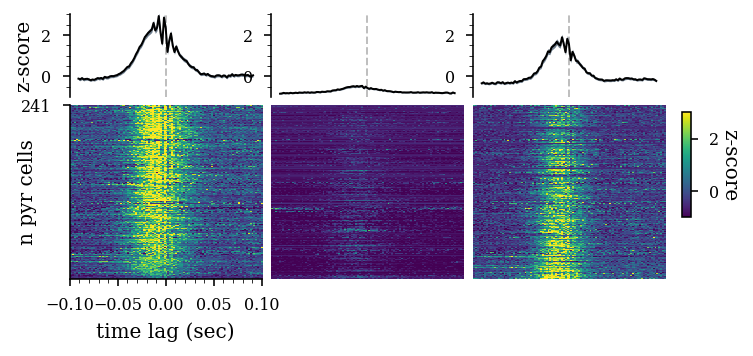

In [52]:
def confidence_intervals(X,conf=0.95):
    # remove nans
    X = X[np.sum(np.isnan(X),axis=1) == 0,:]
    # compute interval for each column
    interval = [stats.t.interval(conf, len(a) - 1, loc = np.mean(a), scale = stats.sem(a)) for a in X.T]
    interval = np.vstack(interval)
    lower = interval[:,0]
    upper = interval[:,1]
    return lower,upper

fig = plt.figure(figsize=functions.set_size('thesis', fraction=1, subplots=(2,3)),constrained_layout=False)
gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.05)

y_min = -1
y_max = 3
heatmap_factor = 1

# mean CI plots
ax0 = fig.add_subplot(gs[0, 0])
lower,upper= confidence_intervals(ccgs[0].values.T)
ax0.plot(results['ccg'][0].index,np.nanmean(ccgs[0],axis=1),'k',linewidth=1)
ax0.fill_between(ccgs[0].index, lower, upper, color="slategrey", alpha = 1, linewidth = 0)

ax1 = fig.add_subplot(gs[0, 1])
lower,upper= confidence_intervals(ccgs[1].values.T)
ax1.plot(ccgs[1].index,np.nanmean(ccgs[1],axis=1),'k',linewidth=1)
ax1.fill_between(ccgs[1].index, lower, upper, color="slategrey", alpha = 1, linewidth = 0)

ax2 = fig.add_subplot(gs[0, 2])
lower,upper= confidence_intervals(ccgs[2].values.T)
ax2.plot(ccgs[2].index,np.nanmean(ccgs[2],axis=1),'k',linewidth=1)
ax2.fill_between(ccgs[2].index, lower, upper, color="slategrey", alpha = 1, linewidth = 0)

# heatmaps
# pull participation prob. for sorting
participation_prob_nrem = df[(df.epoch_n == 0) & (df.basepath == results['basepath'])].participation_prob_nrem
sort_idx = np.argsort(-participation_prob_nrem)
sort_idx = np.argsort(-np.max(ccgs[0],axis=0).values)

ax3 = fig.add_subplot(gs[1:,0])
extent = [ccgs[0].index.min(),ccgs[0].index.max(),0,ccgs[0].shape[1]]
ax3.imshow(ccgs[0][sort_idx].T,aspect='auto',interpolation='nearest',extent=extent,vmin=y_min*heatmap_factor,vmax=y_max*heatmap_factor)
ax3.set_yticks([ccgs[0].shape[1]])

ax4 = fig.add_subplot(gs[1:,1])
extent = [ccgs[1].index.min(),ccgs[1].index.max(),0,ccgs[1].shape[1]]
ax4.imshow(ccgs[1][sort_idx].T,aspect='auto',interpolation='nearest',extent=extent,vmin=y_min*heatmap_factor,vmax=y_max*heatmap_factor)

ax5 = fig.add_subplot(gs[1:,2])
extent = [ccgs[2].index.min(),ccgs[2].index.max(),0,ccgs[2].shape[1]]
sm = ax5.imshow(ccgs[2][sort_idx].T,aspect='auto',interpolation='nearest',extent=extent,vmin=y_min*heatmap_factor,vmax=y_max*heatmap_factor)


axs = [ax0,ax1,ax2,ax3,ax4,ax5]
for i in range(6):
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

axs = [ax0,ax1,ax2]
for i in range(3):
    axs[i].spines["bottom"].set_visible(False)
    axs[i].axes.get_xaxis().set_ticks([])
    axs[i].axvline(0, linestyle = '--', linewidth = 1, alpha = 0.5, color = 'grey',zorder=-100)

axs = [ax4,ax5]
for i in range(2):
    axs[i].spines["bottom"].set_visible(False)
    axs[i].spines["left"].set_visible(False)
    axs[i].axes.get_xaxis().set_ticks([])
    axs[i].axes.get_yaxis().set_ticks([])

ax0.set_ylim(y_min,y_max)
ax1.set_ylim(y_min,y_max)
ax2.set_ylim(y_min,y_max)

ax0.set_ylabel('z-score')

ax3.set_xlabel('time lag (sec)')
ax3.set_ylabel('n pyr cells',labelpad=-8)

cax = plt.axes([0.77, 0.3, 0.01, 0.3])
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label('z-score', rotation=270, labelpad=10)

# plt.savefig(os.path.join(fig_save_path,'ripple_psth_heatmap.svg'),dpi=300,bbox_inches='tight')


# Multi-session example

In [195]:
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\ripple_psth'

sessions = glob.glob(save_path +os.sep+ '*.pkl')

# count number of total units 
n_cells = []
for session in sessions:
    with open(session, 'rb') as f:
        results = pickle.load(f)
    n_cells.append(results['ccg'][0].shape[1])

# set up empty pandas for ccgs
bin_width,n_bins = 0.002,100
times = np.arange(0, bin_width*(n_bins+1), bin_width) - (n_bins*bin_width)/2	
ccg = []
ccg.append(pd.DataFrame(index = times, columns = np.arange(sum(n_cells))))
ccg.append(pd.DataFrame(index = times, columns = np.arange(sum(n_cells))))
ccg.append(pd.DataFrame(index = times, columns = np.arange(sum(n_cells))))

all_results = {}
all_results['ccg'] = ccg

# iter over each epoch (pre/task/post)
for i in range(len(results['ccg'])):
    # this value should go from 0 to sum(n_cells) 3 times
    cell_i = 0
    # iter over sessions
    for session in sessions:
        # open file and get data
        with open(session, 'rb') as f:
            results = pickle.load(f)
        # pull out every ccg from the session from epoch i
        for j in range(results['ccg'][i].shape[1]):
            # store ccg
            all_results['ccg'][i][cell_i] = results['ccg'][i][j]
            # advance idx all the way to sum(n_cells) 
            cell_i+=1

In [198]:
ccgs = []
ccgs.append(all_results['ccg'][0])
ccgs.append(all_results['ccg'][1])
ccgs.append(all_results['ccg'][2])


# Ripple PSTH pre / task / post example

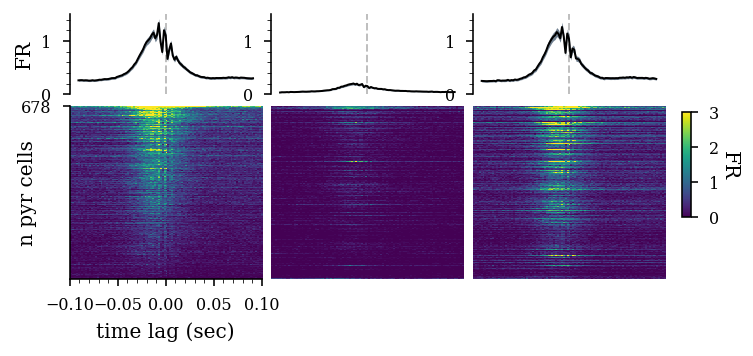

In [234]:
def confidence_intervals(X,conf=0.95):
    # remove nans
    X = X[np.sum(np.isnan(X),axis=1) == 0,:]
    # compute interval for each column
    interval = [stats.t.interval(conf, len(a) - 1, loc = np.mean(a), scale = stats.sem(a)) for a in X.T]
    interval = np.vstack(interval)
    lower = interval[:,0]
    upper = interval[:,1]
    return lower,upper
    
def std_upper_lower(X):
    upper = np.nanmean(X,axis=1) + np.nanstd(X,axis=1)
    lower = np.nanmean(X,axis=1) - np.nanstd(X,axis=1)
    return lower,upper

fig = plt.figure(figsize=functions.set_size('thesis', fraction=1, subplots=(2,3)),constrained_layout=False)
gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.75,
                      hspace=0.15, wspace=0.05)

y_min = 0
y_max = 1.5
heatmap_factor = 2

# mean CI plots
ax0 = fig.add_subplot(gs[0, 0])
lower,upper= confidence_intervals(ccgs[0].values.T)
ax0.plot(results['ccg'][0].index,np.nanmean(ccgs[0],axis=1),'k',linewidth=1)
ax0.fill_between(ccgs[0].index, lower, upper, color="slategrey", alpha = 1, linewidth = 0)

ax1 = fig.add_subplot(gs[0, 1])
lower,upper= confidence_intervals(ccgs[1].values.T)
ax1.plot(ccgs[1].index,np.nanmean(ccgs[1],axis=1),'k',linewidth=1)
ax1.fill_between(ccgs[1].index, lower, upper, color="slategrey", alpha = 1, linewidth = 0)

ax2 = fig.add_subplot(gs[0, 2])
lower,upper= confidence_intervals(ccgs[2].values.T)
ax2.plot(ccgs[2].index,np.nanmean(ccgs[2],axis=1),'k',linewidth=1)
ax2.fill_between(ccgs[2].index, lower, upper, color="slategrey", alpha = 1, linewidth = 0)

# heatmaps
# sort_idx = np.argsort(-np.max(ccgs[0],axis=0).values)
participation_prob_nrem = df[(df.epoch_n == 0)].participation_prob_nrem
sort_idx = np.argsort(-participation_prob_nrem)

ax3 = fig.add_subplot(gs[1:,0])
extent = [ccgs[0].index.min(),ccgs[0].index.max(),0,ccgs[0].shape[1]]
ax3.imshow(ccgs[0][sort_idx].T,aspect='auto',interpolation='nearest',extent=extent,vmin=y_min*heatmap_factor,vmax=y_max*heatmap_factor)
ax3.set_yticks([ccgs[0].shape[1]])

ax4 = fig.add_subplot(gs[1:,1])
extent = [ccgs[1].index.min(),ccgs[1].index.max(),0,ccgs[1].shape[1]]
ax4.imshow(ccgs[1][sort_idx].T,aspect='auto',interpolation='nearest',extent=extent,vmin=y_min*heatmap_factor,vmax=y_max*heatmap_factor)

ax5 = fig.add_subplot(gs[1:,2])
extent = [ccgs[2].index.min(),ccgs[2].index.max(),0,ccgs[2].shape[1]]
sm = ax5.imshow(ccgs[2][sort_idx].T,aspect='auto',interpolation='nearest',extent=extent,vmin=y_min*heatmap_factor,vmax=y_max*heatmap_factor)


axs = [ax0,ax1,ax2,ax3,ax4,ax5]
for i in range(6):
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

axs = [ax0,ax1,ax2]
for i in range(3):
    axs[i].spines["bottom"].set_visible(False)
    axs[i].axes.get_xaxis().set_ticks([])
    axs[i].axvline(0, linestyle = '--', linewidth = 1, alpha = 0.5, color = 'grey',zorder=-100)

axs = [ax4,ax5]
for i in range(2):
    axs[i].spines["bottom"].set_visible(False)
    axs[i].spines["left"].set_visible(False)
    axs[i].axes.get_xaxis().set_ticks([])
    axs[i].axes.get_yaxis().set_ticks([])

ax0.set_ylim(y_min,y_max)
ax1.set_ylim(y_min,y_max)
ax2.set_ylim(y_min,y_max)

ax0.set_ylabel('FR')

ax3.set_xlabel('time lag (sec)')
ax3.set_ylabel('n pyr cells',labelpad=-8)

cax = plt.axes([0.77, 0.3, 0.01, 0.3])
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label('FR', rotation=270, labelpad=10)

plt.savefig(os.path.join(fig_save_path,'ripple_psth_heatmap_raw_rate.svg'),dpi=300,bbox_inches='tight')


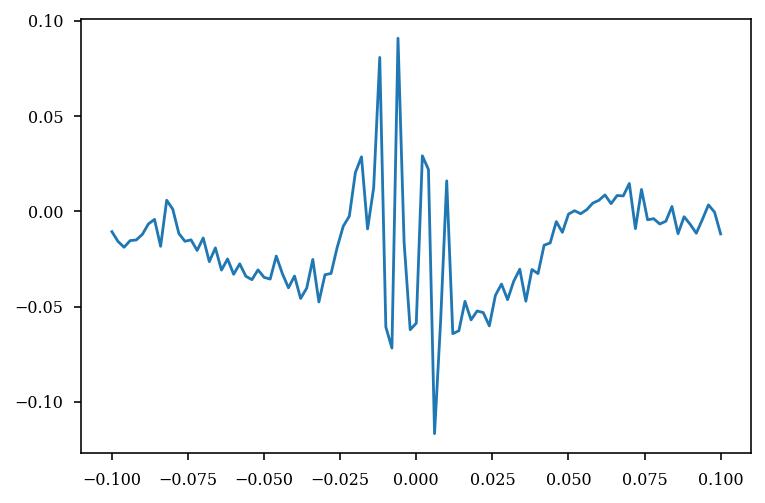

In [282]:
ratio_psth = ccgs[2]-ccgs[0]

plt.plot(np.mean(ratio_psth,axis=1))

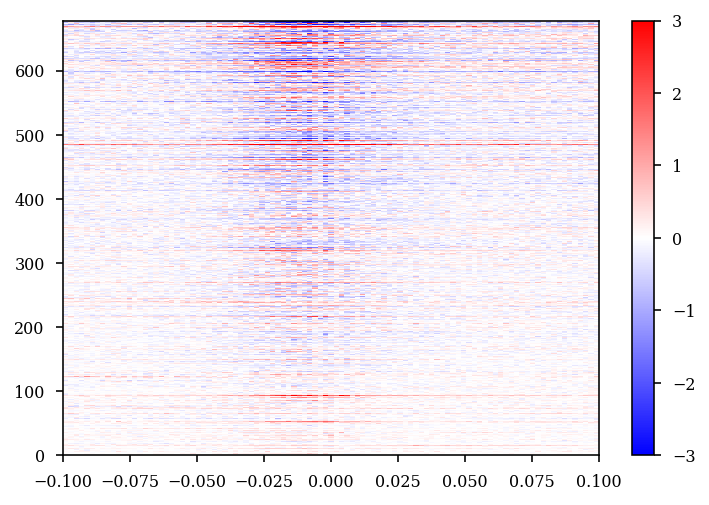

In [285]:
# ratio_psth = (ccgs[2]-ccgs[0]) / (ccgs[2]+ccgs[0])
ratio_psth = ccgs[2]-ccgs[0]
plt.imshow(ratio_psth[sort_idx].T,aspect='auto',interpolation='nearest',cmap='bwr',extent=extent,vmax=3,vmin=-3)
plt.colorbar()
plt.show()

# ratio_psth = ccgs[1]-ccgs[0]
# plt.imshow(ratio_psth[sort_idx].T,aspect='auto',interpolation='nearest',cmap='bwr',extent=extent,vmax=3,vmin=-3)
# plt.colorbar()
# plt.show()

# from matplotlib.colors import LogNorm

# ratio_psth = ccgs[2]/ccgs[0]
# plt.imshow(ratio_psth[sort_idx].T,aspect='auto',interpolation='nearest',extent=extent,norm=LogNorm())
# # plt.yscale('log')
# plt.colorbar()
# plt.show()

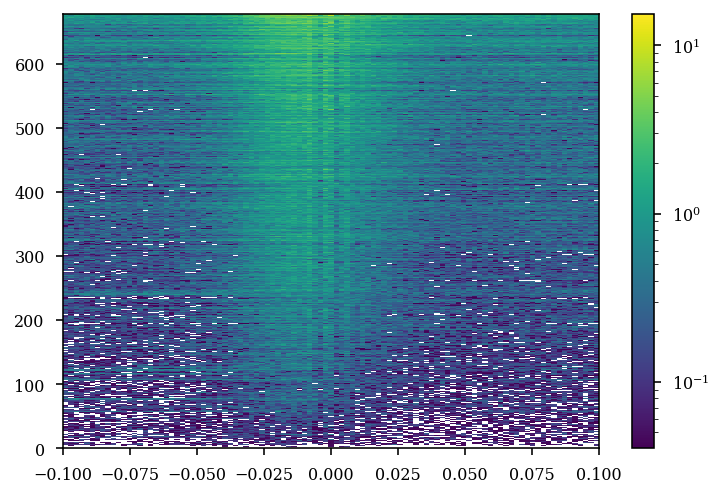

In [284]:

plt.imshow(ccgs[0][sort_idx].T,aspect='auto',interpolation='nearest',extent=extent,norm=LogNorm())
plt.colorbar()

(0.0, 6.0)

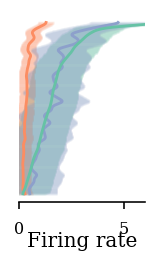

In [231]:
from scipy.ndimage import gaussian_filter1d

fig = plt.figure(figsize=functions.set_size('thesis', fraction=.19, subplots=(2.5,1)),constrained_layout=False)

sort_idx = np.argsort(np.max(ccgs[0],axis=0).values)

# group_colors = {'0':'#a6bddb','1':'#3690c0','2':'#045a8d'}
cmap = matplotlib.cm.get_cmap('viridis',5)
cmap = matplotlib.cm.get_cmap('Set2',8)


x = np.arange(ccgs[0].shape[1])
plt.plot(gaussian_filter1d(np.max(ccgs[0].values,axis=0)[sort_idx],10),x,color=cmap(0),zorder=100)
xerr = np.std(np.max(ccgs[0].values,axis=0))
plt.errorbar(np.max(ccgs[0].values,axis=0)[sort_idx], x, xerr = xerr,color=cmap(0),zorder=-100,alpha=.05)

plt.plot(gaussian_filter1d(np.max(ccgs[1].values,axis=0)[sort_idx],10),x,color=cmap(1))
xerr = np.std(np.max(ccgs[1].values,axis=0))
plt.errorbar(gaussian_filter1d(np.max(ccgs[1].values,axis=0)[sort_idx],10), x, xerr = xerr,color=cmap(1),zorder=-100,alpha=.05)

plt.plot(gaussian_filter1d(np.max(ccgs[2].values,axis=0)[sort_idx],10),x,color=cmap(2))
xerr = np.std(np.max(ccgs[2].values,axis=0))
plt.errorbar(gaussian_filter1d(np.max(ccgs[2].values,axis=0)[sort_idx],10), x, xerr = xerr,color=cmap(2),zorder=-100,alpha=.05)

plt.xlabel('Firing rate',labelpad=-3)
axs = plt.gca()
# axs.axes.get_xaxis().set_ticks([])
axs.axes.get_yaxis().set_ticks([])
axs.spines["left"].set_visible(False)
axs.spines["right"].set_visible(False)
axs.spines["top"].set_visible(False)

axs.set_xlim(0,6)
# plt.savefig(os.path.join(fig_save_path,'peak_distribution_pre_task_post.svg'),dpi=300,bbox_inches='tight')


## zscored example

In [5]:
temp_df = pd.DataFrame()
temp_df = temp_df.append(all_results['ccg'][0],ignore_index=True)
temp_df = temp_df.append(all_results['ccg'][1],ignore_index=True)
temp_df = temp_df.append(all_results['ccg'][2],ignore_index=True)
zscored = stats.zscore(temp_df,axis=0)
ccgs = []

ccgs.append(zscored.loc[0:100,:])
ccgs.append(zscored.loc[101:201,:])
ccgs.append(zscored.loc[202:,:])

# add ts index back
bin_width,n_bins = 0.002,100

times = np.arange(0, bin_width*(n_bins+1), bin_width) - (n_bins*bin_width)/2	
ccgs[0] = ccgs[0].set_index([pd.Index(times)])
ccgs[1] = ccgs[1].set_index([pd.Index(times)])
ccgs[2] = ccgs[2].set_index([pd.Index(times)])

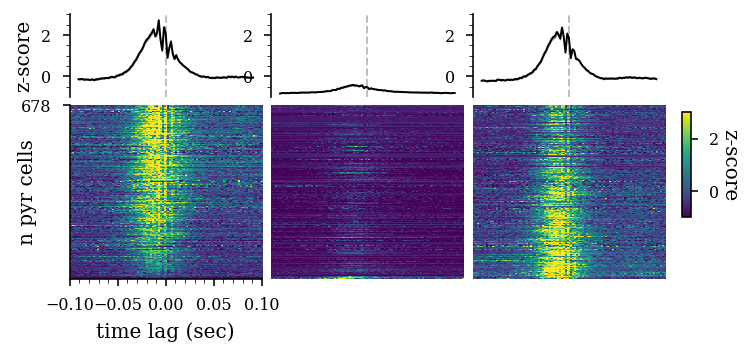

In [194]:
def confidence_intervals(X,conf=0.95):
    # remove nans
    X = X[np.sum(np.isnan(X),axis=1) == 0,:]
    # compute interval for each column
    interval = [stats.t.interval(conf, len(a) - 1, loc = np.mean(a), scale = stats.sem(a)) for a in X.T]
    interval = np.vstack(interval)
    lower = interval[:,0]
    upper = interval[:,1]
    return lower,upper
    
def std_upper_lower(X):
    upper = np.nanmean(X,axis=1) + np.nanstd(X,axis=1)
    lower = np.nanmean(X,axis=1) - np.nanstd(X,axis=1)
    return lower,upper

fig = plt.figure(figsize=functions.set_size('thesis', fraction=1, subplots=(2,3)),constrained_layout=False)
gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.05)

y_min = -1
y_max = 3
heatmap_factor = 1

# mean CI plots
ax0 = fig.add_subplot(gs[0, 0])
lower,upper= confidence_intervals(ccgs[0].values.T)
ax0.plot(results['ccg'][0].index,np.nanmean(ccgs[0],axis=1),'k',linewidth=1)
ax0.fill_between(ccgs[0].index, lower, upper, color="slategrey", alpha = 1, linewidth = 0)

ax1 = fig.add_subplot(gs[0, 1])
lower,upper= confidence_intervals(ccgs[1].values.T)
ax1.plot(ccgs[1].index,np.nanmean(ccgs[1],axis=1),'k',linewidth=1)
ax1.fill_between(ccgs[1].index, lower, upper, color="slategrey", alpha = 1, linewidth = 0)

ax2 = fig.add_subplot(gs[0, 2])
lower,upper= confidence_intervals(ccgs[2].values.T)
ax2.plot(ccgs[2].index,np.nanmean(ccgs[2],axis=1),'k',linewidth=1)
ax2.fill_between(ccgs[2].index, lower, upper, color="slategrey", alpha = 1, linewidth = 0)

# heatmaps
sort_idx = np.argsort(-np.max(ccgs[0],axis=0).values)
# participation_prob_nrem = df[(df.epoch_n == 0)].participation_prob_nrem
# sort_idx = np.argsort(-participation_prob_nrem)

ax3 = fig.add_subplot(gs[1:,0])
extent = [ccgs[0].index.min(),ccgs[0].index.max(),0,ccgs[0].shape[1]]
ax3.imshow(ccgs[0][sort_idx].T,aspect='auto',interpolation='nearest',extent=extent,vmin=y_min*heatmap_factor,vmax=y_max*heatmap_factor)
ax3.set_yticks([ccgs[0].shape[1]])

ax4 = fig.add_subplot(gs[1:,1])
extent = [ccgs[1].index.min(),ccgs[1].index.max(),0,ccgs[1].shape[1]]
ax4.imshow(ccgs[1][sort_idx].T,aspect='auto',interpolation='nearest',extent=extent,vmin=y_min*heatmap_factor,vmax=y_max*heatmap_factor)

ax5 = fig.add_subplot(gs[1:,2])
extent = [ccgs[2].index.min(),ccgs[2].index.max(),0,ccgs[2].shape[1]]
sm = ax5.imshow(ccgs[2][sort_idx].T,aspect='auto',interpolation='nearest',extent=extent,vmin=y_min*heatmap_factor,vmax=y_max*heatmap_factor)


axs = [ax0,ax1,ax2,ax3,ax4,ax5]
for i in range(6):
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

axs = [ax0,ax1,ax2]
for i in range(3):
    axs[i].spines["bottom"].set_visible(False)
    axs[i].axes.get_xaxis().set_ticks([])
    axs[i].axvline(0, linestyle = '--', linewidth = 1, alpha = 0.5, color = 'grey',zorder=-100)

axs = [ax4,ax5]
for i in range(2):
    axs[i].spines["bottom"].set_visible(False)
    axs[i].spines["left"].set_visible(False)
    axs[i].axes.get_xaxis().set_ticks([])
    axs[i].axes.get_yaxis().set_ticks([])

ax0.set_ylim(y_min,y_max)
ax1.set_ylim(y_min,y_max)
ax2.set_ylim(y_min,y_max)

ax0.set_ylabel('z-score')

ax3.set_xlabel('time lag (sec)')
ax3.set_ylabel('n pyr cells',labelpad=-8)

cax = plt.axes([0.77, 0.3, 0.01, 0.3])
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label('z-score', rotation=270, labelpad=10)

plt.savefig(os.path.join(fig_save_path,'ripple_psth_heatmap.svg'),dpi=300,bbox_inches='tight')


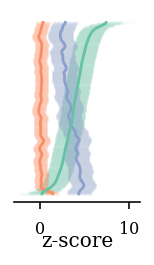

In [188]:
from scipy.ndimage import gaussian_filter1d

fig = plt.figure(figsize=functions.set_size('thesis', fraction=.19, subplots=(2.5,1)),constrained_layout=False)

sort_idx = np.argsort(np.max(ccgs[0],axis=0).values)

# group_colors = {'0':'#a6bddb','1':'#3690c0','2':'#045a8d'}
cmap = matplotlib.cm.get_cmap('viridis',5)
cmap = matplotlib.cm.get_cmap('Set2',8)


x = np.arange(ccgs[0].shape[1])
plt.plot(gaussian_filter1d(np.max(ccgs[0].values,axis=0)[sort_idx],10),x,color=cmap(0),zorder=100)
xerr = np.std(np.max(ccgs[0].values,axis=0))
plt.errorbar(np.max(ccgs[0].values,axis=0)[sort_idx], x, xerr = xerr,color=cmap(0),zorder=-100,alpha=.05)

plt.plot(gaussian_filter1d(np.max(ccgs[1].values,axis=0)[sort_idx],10),x,color=cmap(1))
xerr = np.std(np.max(ccgs[1].values,axis=0))
plt.errorbar(gaussian_filter1d(np.max(ccgs[1].values,axis=0)[sort_idx],10), x, xerr = xerr,color=cmap(1),zorder=-100,alpha=.05)

plt.plot(gaussian_filter1d(np.max(ccgs[2].values,axis=0)[sort_idx],10),x,color=cmap(2))
xerr = np.std(np.max(ccgs[2].values,axis=0))
plt.errorbar(gaussian_filter1d(np.max(ccgs[2].values,axis=0)[sort_idx],10), x, xerr = xerr,color=cmap(2),zorder=-100,alpha=.05)

plt.xlabel('z-score',labelpad=-3)
axs = plt.gca()
# axs.axes.get_xaxis().set_ticks([])
axs.axes.get_yaxis().set_ticks([])
axs.spines["left"].set_visible(False)
axs.spines["right"].set_visible(False)
axs.spines["top"].set_visible(False)

plt.savefig(os.path.join(fig_save_path,'peak_distribution_pre_task_post.svg'),dpi=300,bbox_inches='tight')


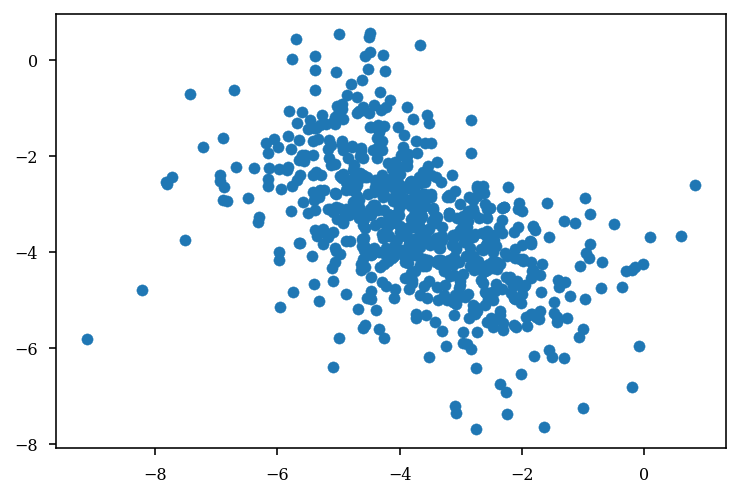

In [27]:
plt.scatter(-np.max(ccgs[0].values,axis=0)[sort_idx],-np.max(ccgs[2].values,axis=0)[sort_idx])

In [68]:
# temp_df = pd.DataFrame()
# temp_df['ccg'] = np.hstack([np.max(ccgs[0].values,axis=0),np.max(ccgs[1].values,axis=0),np.max(ccgs[2].values,axis=0)])

# sort_idx = np.argsort(np.max(ccgs[0],axis=0).values)
# temp_df['sort_idx'] = np.hstack([sort_idx,sort_idx,sort_idx])

# temp_df['epoch'] = np.hstack([['epoch_1']*len(sort_idx),['epoch_2']*len(sort_idx),['epoch_3']*len(sort_idx)])

# sns.lineplot(x="sort_idx", y="ccg",
#              hue="epoch",
#              data=temp_df)